In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
import seaborn as sns
from bokeh.plotting import figure, show
from bokeh.io import output_notebook,curdoc, show,output_file
from bokeh.models import ColumnDataSource, FactorRange,Grid, HBar, LinearAxis, Plot,LabelSet,Legend,CDSView,BooleanFilter
from bokeh.core.properties import value
from bokeh.transform import factor_cmap,dodge
from bokeh.palettes import Spectral10
from bokeh.models import HoverTool, Panel, Tabs,Range1d
from bokeh.models import Select, TextInput
from bokeh.layouts import column,row
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
from matplotlib import cm



# select a palette
from bokeh.palettes import Spectral5
from bokeh.palettes import Category20 as palette1
from bokeh.palettes import Category10 as palette2

# itertools handles the cycling
import itertools  
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn import tree

sns.set(style='darkgrid', palette='muted', color_codes=True)



# Magic command useful for jupyter notebook
%matplotlib inline

# Set plot size. 
plt.rcParams['figure.figsize'] = [13, 6]

# Set font size
plt.rcParams.update({'font.size': 22})

## Pre processing

In [26]:
df_pure = pd.read_csv('data/Motor_Vehicle_Collisions_-_Crashes.csv')
df_crash = pd.read_csv('data/crash_clean.csv')
df_vehicle = pd.read_csv('data/vehicle_clean.csv')
df_people = pd.read_csv('data/people_clean.csv')

In [27]:
df_crash['CRASH DATE'] = pd.to_datetime(df_crash['CRASH DATE'])
df_crash['CRASH TIME'] = pd.to_datetime(df_crash['CRASH TIME']) 
df_pure['CRASH DATE'] = pd.to_datetime(df_pure['CRASH DATE'])
df_pure['CRASH TIME'] = pd.to_datetime(df_pure['CRASH TIME']) 

In [28]:
df_plot = df_crash[['CRASH DATE','BOROUGH','NUMBER OF PERSONS INJURED']]
df_plot = df_plot[~df_plot.isin(['Unspecified'])]
df_plot = df_plot.dropna()
df_plot.rename(columns={'CRASH DATE':'CRASHDATE','NUMBER OF PERSONS INJURED':'INJURED'},inplace=True)
df_plot['CRASHDATE'] = pd.to_datetime(df_plot['CRASHDATE']).dt.year
df_plot['CRASHDATE'] = df_plot['CRASHDATE'].astype(str)
df_plot['BOROUGH'] = df_plot['BOROUGH'].astype(str)
group = df_plot.groupby(by=['BOROUGH', 'CRASHDATE'])

In [31]:
from bokeh.palettes import Category20b_13 as palette3

In [34]:
index_cmap = factor_cmap('BOROUGH_CRASHDATE', palette=palette3, factors=sorted(df_plot.BOROUGH.unique()), end=1)

TOOLTIPS = tooltips=[('Injured','@INJURED_count'),('Year, Borough','@BOROUGH_CRASHDATE')]

p = figure(plot_width=800, plot_height=300, title="Injuries by Year and Borough",
           x_range=group,tooltips=TOOLTIPS)

p.vbar(x='BOROUGH_CRASHDATE', top='INJURED_count', width=1, source=group,
       line_color="white", fill_color=index_cmap, )
p.y_range.start = 0
p.x_range.range_padding = 0.05
p.xgrid.grid_line_color = None
p.yaxis.axis_label = "Count"
p.xaxis.major_label_orientation = 1.2
p.outline_line_color = None
# output_file("yearly_borough.html")
show(p)

### Heatmap plots 

In [113]:
df_crash.head()

Unnamed: 0 CRASH DATE          CRASH TIME      BOROUGH   LATITUDE  \
0           1 2016-06-01 2020-05-13 13:54:00       QUEENS  40.655834   
1           2 2016-05-23 2020-05-13 06:15:00  Unspecified  40.752937   
2           3 2016-06-03 2020-05-13 11:00:00  Unspecified  40.680893   
3           4 2016-06-03 2020-05-13 17:15:00       QUEENS  40.665558   
4           5 2016-06-04 2020-05-13 13:20:00     BROOKLYN  40.689530   

   LONGITUDE                    ON STREET NAME NUMBER OF PERSONS INJURED  \
0 -73.839035  CROSS BAY BOULEVARD                                    0.0   
1 -73.922040  NORTHERN BOULEVARD                                     0.0   
2 -73.871376  GLEN STREET                                            1.0   
3 -73.729850  HOOK CREEK BOULEVARD                                   0.0   
4 -73.909134                       Unspecified                       0.0   

  NUMBER OF PERSONS KILLED  NUMBER OF PEDESTRIANS INJURED  ...  \
0                      0.0                              0  ...   
1                      0.0                              0  ...   
2                      0.0                              1  ...   
3                      0.0                              0  ...   
4                      0.0                              0  ...   

   NUMBER OF CYCLIST KILLED  NUMBER OF MOTORIST INJURED  \
0                         0                           0   
1                         0                           0   
2                         0                           0   
3                         0                           0   
4                         0                           0   

   NUMBER OF MOTORIST KILLED   CONTRIBUTING FACTOR VEHICLE 1  \
0                          0  Driver Inattention/Distraction   
1                          0  Driver Inattention/Distraction   
2                          0   Failure to Yield Right-of-Way   
3                          0                     Unspecified   
4                          0             Passing Too Closely   

    CONTRIBUTING FACTOR VEHICLE 2 COLLISION_ID VEHICLE TYPE CODE 1  \
0  Driver Inattention/Distraction      3453947   PASSENGER VEHICLE   
1                     Unspecified      3452402   PASSENGER VEHICLE   
2                     Unspecified      3482311   PASSENGER VEHICLE   
3                     Unspecified      3455499   PASSENGER VEHICLE   
4                     Unspecified      3455042   PASSENGER VEHICLE   

   VEHICLE TYPE CODE 2           lon           lat  
0    PASSENGER VEHICLE -8.219724e+06  4.961709e+06  
1    PASSENGER VEHICLE -8.228964e+06  4.975968e+06  
2          Unspecified -8.223324e+06  4.965387e+06  
3    PASSENGER VEHICLE -8.207569e+06  4.963136e+06  
4    PASSENGER VEHICLE -8.227527e+06  4.966655e+06  

[5 rows x 22 columns]

In [37]:
df_crash.dtypes

Unnamed: 0                                int64
CRASH DATE                       datetime64[ns]
CRASH TIME                       datetime64[ns]
BOROUGH                                  object
LATITUDE                                float64
LONGITUDE                               float64
ON STREET NAME                           object
NUMBER OF PERSONS INJURED                object
NUMBER OF PERSONS KILLED                 object
NUMBER OF PEDESTRIANS INJURED             int64
NUMBER OF PEDESTRIANS KILLED              int64
NUMBER OF CYCLIST INJURED                 int64
NUMBER OF CYCLIST KILLED                  int64
NUMBER OF MOTORIST INJURED                int64
NUMBER OF MOTORIST KILLED                 int64
CONTRIBUTING FACTOR VEHICLE 1            object
CONTRIBUTING FACTOR VEHICLE 2            object
COLLISION_ID                              int64
VEHICLE TYPE CODE 1                      object
VEHICLE TYPE CODE 2                      object
dtype: object

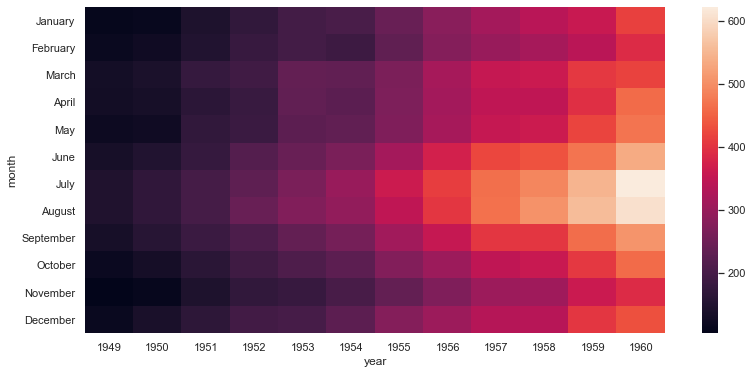

In [38]:
flights = sns.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")
ax = sns.heatmap(flights)


In [39]:
df_pure

CRASH DATE          CRASH TIME BOROUGH ZIP CODE   LATITUDE  LONGITUDE  \
0       2016-05-14 2020-05-13 18:00:00   BRONX    10472        NaN        NaN   
1       2016-06-01 2020-05-13 13:54:00  QUEENS    11414  40.655834 -73.839035   
2       2016-05-23 2020-05-13 06:15:00     NaN      NaN  40.752937 -73.922040   
3       2016-06-03 2020-05-13 11:00:00     NaN      NaN  40.680893 -73.871376   
4       2016-06-03 2020-05-13 17:15:00  QUEENS    11422  40.665558 -73.729850   
...            ...                 ...     ...      ...        ...        ...   
1672370 2013-08-20 2020-05-13 12:39:00     NaN      NaN        NaN        NaN   
1672371 2013-08-20 2020-05-13 14:00:00     NaN      NaN        NaN        NaN   
1672372 2013-08-20 2020-05-13 22:30:00     NaN      NaN        NaN        NaN   
1672373 2013-08-20 2020-05-13 08:50:00     NaN      NaN        NaN        NaN   
1672374 2013-08-18 2020-05-13 11:20:00     NaN      NaN        NaN        NaN   

                             LOCATION                    ON STREET NAME  \
0                                 NaN  WHITE PLAINS ROAD                  
1        POINT (-73.839035 40.655834)  CROSS BAY BOULEVARD                
2         POINT (-73.92204 40.752937)  NORTHERN BOULEVARD                 
3        POINT (-73.871376 40.680893)  GLEN STREET                        
4         POINT (-73.72985 40.665558)  HOOK CREEK BOULEVARD               
...                               ...                               ...   
1672370                           NaN                               NaN   
1672371                           NaN                               NaN   
1672372                           NaN                               NaN   
1672373                           NaN                               NaN   
1672374                           NaN                               NaN   

              CROSS STREET NAME OFF STREET NAME  ...  \
0        CROSS BRONX EXPRESSWAY             NaN  ...   
1                    161 AVENUE             NaN  ...   
2                           NaN             NaN  ...   
3                           NaN             NaN  ...   
4               SUNRISE HIGHWAY             NaN  ...   
...                         ...             ...  ...   
1672370                     NaN             NaN  ...   
1672371                     NaN             NaN  ...   
1672372                     NaN             NaN  ...   
1672373                     NaN             NaN  ...   
1672374                     NaN             NaN  ...   

          CONTRIBUTING FACTOR VEHICLE 2  CONTRIBUTING FACTOR VEHICLE 3  \
0                           Unspecified                            NaN   
1        Driver Inattention/Distraction                            NaN   
2                           Unspecified                            NaN   
3                                   NaN                            NaN   
4                           Unspecified                            NaN   
...                                 ...                            ...   
1672370                     Unspecified                            NaN   
1672371              Lost Consciousness                            NaN   
1672372                     Unspecified                            NaN   
1672373                     Unspecified                            NaN   
1672374                             NaN                            NaN   

         CONTRIBUTING FACTOR VEHICLE 4  CONTRIBUTING FACTOR VEHICLE 5  \
0                                  NaN                            NaN   
1                                  NaN                            NaN   
2                                  NaN                            NaN   
3                                  NaN                            NaN   
4                                  NaN                            NaN   
...                                ...                            ...   
1672370                            NaN                       

In [40]:
hmap = df_pure.groupby([df_pure['CRASH DATE'].dt.month, df_pure['CRASH DATE'].dt.year])
hmap=hmap.size().unstack()

In [41]:
hmap = hmap.rename_axis(index={'CRASH DATE': 'Month'},columns={'CRASH DATE': 'Year'}).fillna(0).astype(int)

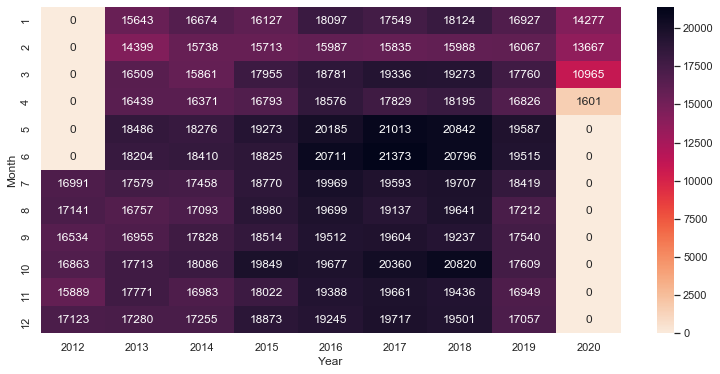

In [42]:
cmap = sns.cm.rocket_r
ax = sns.heatmap(hmap,annot=True,fmt="d",annot_kws={"size": 12},cmap = cmap)

In [43]:
ax.get_figure().savefig("docs/output.png",bbox_inches='tight')

In [78]:
#sns.choose_light_palette() 

## Inteactive bokeh plot of dangerous intersections. 

In [4]:
df_crash['ON STREET NAME'] = df_crash['ON STREET NAME'].str.strip()
df_crash = df_crash[df_crash['ON STREET NAME'] != 'Unspecified']

In [18]:
total =df_crash.groupby('ON STREET NAME').size()

In [19]:
obj = df_crash.groupby(['ON STREET NAME','BOROUGH'], as_index = False).size().sort_values(ascending = False)

In [20]:
obj

ON STREET NAME              BOROUGH      
BELT PARKWAY                Unspecified      10415
ATLANTIC AVENUE             BROOKLYN          9381
NORTHERN BOULEVARD          QUEENS            8268
LONG ISLAND EXPRESSWAY      Unspecified       8194
BROOKLYN QUEENS EXPRESSWAY  Unspecified       7979
                                             ...  
FOOTHILL COURT              STATEN ISLAND        1
FONDA AVENUE                QUEENS               1
FOLSOM PLACE                BROOKLYN             1
FOCH AVENUE                 Unspecified          1
                            BRONX                1
Length: 13018, dtype: int64

In [21]:
output_notebook()

Loading BokehJS ...

In [41]:
fruits =obj.loc[:, 'MANHATTAN'].nlargest(10).index.to_list()
years = obj.loc[:, 'MANHATTAN'].nlargest(10).values
data = {'fruits' : fruits,
        'count'   : years}
source = ColumnDataSource(data=data)

sorted_fruits = sorted(fruits, key=lambda x: years[fruits.index(x)])

p = figure(y_range=FactorRange(factors=sorted_fruits), x_range=(0, 13000), plot_width=800,plot_height=400,title="Total recorded accidents ")
p.hbar(y='fruits', right='count', height=0.7, source=source)
#p.text([12000,12000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],[2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], text=[ str(i) for i in years], alpha=0.5, text_font_size="10pt", text_baseline="middle", text_align="center")
p.y_range.range_padding = 0.1
p.ygrid.grid_line_color = None
show(p)
tab1 = Panel(child=p, title="Violations by hours")

In [20]:
test1 =obj.loc[:, 'QUEENS'].nlargest(10).index.to_list()
test2 = obj.loc[:, 'QUEENS'].nlargest(10).values

In [55]:

# Hover tool
hover = HoverTool(mode = "mouse")
hover.tooltips=[
    ('Total crashes', "@count"), #$name provides data from legend
]


fruits =obj.loc[:, 'QUEENS'].nlargest(10).index.to_list()
years = obj.loc[:, 'QUEENS'].nlargest(10).values
data = {'fruits' : fruits,
        'count'   : years}
source = ColumnDataSource(data=data)
sorted_fruits = sorted(fruits, key=lambda x: years[fruits.index(x)])
p = figure(y_range=FactorRange(factors=sorted_fruits), x_range=(0, 13000), plot_width=800,plot_height=400,title="Total recorded accidents ")
p.hbar(y='fruits', right='count', height=0.7, source=source)
#p.text([12000,12000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],[2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], text=[ str(i) for i in years], alpha=0.5, text_font_size="10pt", text_baseline="middle", text_align="center")
p.y_range.range_padding = 0.1
p.add_tools(hover)
p.ygrid.grid_line_color = None
tab1 = Panel(child=p, title="Queens")

fruits =obj.loc[:, 'MANHATTAN'].nlargest(10).index.to_list()
years = obj.loc[:, 'MANHATTAN'].nlargest(10).values
data = {'fruits' : fruits,
        'count'   : years}
source = ColumnDataSource(data=data)
sorted_fruits = sorted(fruits, key=lambda x: years[fruits.index(x)])
p1 = figure(y_range=FactorRange(factors=sorted_fruits), x_range=(0, 13000), plot_width=800,plot_height=400,title="Total recorded accidents ")
p1.hbar(y='fruits', right='count', height=0.7, source=source)
#p.text([12000,12000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],[2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], text=[ str(i) for i in years], alpha=0.5, text_font_size="10pt", text_baseline="middle", text_align="center")
p1.y_range.range_padding = 0.1
p1.add_tools(hover)
p1.ygrid.grid_line_color = None
tab2 = Panel(child=p1, title="Manhatten")

fruits =obj.loc[:, 'STATEN ISLAND'].nlargest(10).index.to_list()
years = obj.loc[:, 'STATEN ISLAND'].nlargest(10).values
data = {'fruits' : fruits,
        'count'   : years}
source = ColumnDataSource(data=data)
sorted_fruits = sorted(fruits, key=lambda x: years[fruits.index(x)])
p2 = figure(y_range=FactorRange(factors=sorted_fruits), x_range=(0, 13000), plot_width=800,plot_height=400,title="Total recorded accidents ")
p2.hbar(y='fruits', right='count', height=0.7, source=source)
#p.text([12000,12000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],[2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], text=[ str(i) for i in years], alpha=0.5, text_font_size="10pt", text_baseline="middle", text_align="center")
p2.y_range.range_padding = 0.1
p2.ygrid.grid_line_color = None
p2.add_tools(hover)
tab3 = Panel(child=p2, title="Staten Island")

fruits =obj.loc[:, 'BROOKLYN'].nlargest(10).index.to_list()
years = obj.loc[:, 'BROOKLYN'].nlargest(10).values
data = {'fruits' : fruits,
        'count'   : years}
source = ColumnDataSource(data=data)
sorted_fruits = sorted(fruits, key=lambda x: years[fruits.index(x)])
p3 = figure(y_range=FactorRange(factors=sorted_fruits), x_range=(0, 13000), plot_width=800,plot_height=400,title="Total recorded accidents ")
p3.hbar(y='fruits', right='count', height=0.7, source=source)
#p.text([12000,12000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],[2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], text=[ str(i) for i in years], alpha=0.5, text_font_size="10pt", text_baseline="middle", text_align="center")
p3.y_range.range_padding = 0.1
p3.ygrid.grid_line_color = None
p3.add_tools(hover)
tab4 = Panel(child=p3, title="Brooklyn")



fruits =obj.loc[:, 'BRONX'].nlargest(10).index.to_list()
years = obj.loc[:, 'BRONX'].nlargest(10).values
data = {'fruits' : fruits,
        'count'   : years}
source = ColumnDataSource(data=data)
sorted_fruits = sorted(fruits, key=lambda x: years[fruits.index(x)])
p4 = figure(y_range=FactorRange(factors=sorted_fruits), x_range=(0, 10000), plot_width=800,plot_height=400,title="Total recorded accidents ")
p4.hbar(y='fruits', right='count', height=0.7, source=source)
#p.text([12000,12000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],[2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], text=[ str(i) for i in years], alpha=0.5, text_font_size="10pt", text_baseline="middle", text_align="center")
p4.y_range.range_padding = 0.1
p4.ygrid.grid_line_color = None
p4.add_tools(hover)
tab5 = Panel(child=p4, title="Bronx")


In [56]:
tabs1 = Tabs(tabs=[ tab1, tab2, tab3, tab4, tab5])

In [57]:
output_file("docs/Dangerous.html",mode="inline")
show(tabs1)

## Map showing location of intersections

In [9]:
# Make source
df_inter = df_crash[(df_crash['ON STREET NAME'] == 'BROADWAY') | (df_crash['ON STREET NAME'] == 'ATLANTIC AVENUE')\
        | (df_crash['ON STREET NAME'] == '3 AVENUE') | (df_crash['ON STREET NAME'] == '2 AVENUE')\
        | (df_crash['ON STREET NAME'] == 'NORTHERN BOULEVARD') | (df_crash['ON STREET NAME'] == 'QUEENS BOULEVARD')\
        | (df_crash['ON STREET NAME'] == 'WOODHAVEN BOULEVARD') | (df_crash['ON STREET NAME'] == 'HYLAN BOULEVARD')\
        | (df_crash['ON STREET NAME'] == 'RICHMOND ROAD') | (df_crash['ON STREET NAME'] == 'AMBOY ROAD')\
        | (df_crash['ON STREET NAME'] == 'FLATBUSH AVENUE') | (df_crash['ON STREET NAME'] == 'LINDEN BOULEVARD')\
        | (df_crash['ON STREET NAME'] == 'BRUCKNER BOULEVARD')| (df_crash['ON STREET NAME'] == 'EAST TREMONT AVENUE')\
        | (df_crash['ON STREET NAME'] == 'JEROME AVENUE')]

In [10]:
df_inter['test'] = df_inter['ON STREET NAME']
df_inter['vehicle'] = df_inter['CONTRIBUTING FACTOR VEHICLE 1']

In [11]:
df_inter=df_inter[df_inter['NUMBER OF PERSONS KILLED']!='Unspecified']
df_inter['NUMBER OF PERSONS KILLED']=df_inter['NUMBER OF PERSONS KILLED'].astype('float')
df_inter = df_inter[df_inter['CRASH DATE'].dt.year == 2016]

In [12]:
test = get_provider(CARTODBPOSITRON)

In [13]:
df_inter

Unnamed: 0 CRASH DATE          CRASH TIME        BOROUGH   LATITUDE  \
1                 2 2016-05-23 2020-05-15 06:15:00    Unspecified  40.752937   
13               14 2016-05-18 2020-05-15 21:15:00         QUEENS  40.768906   
15               17 2016-05-24 2020-05-15 09:03:00  STATEN ISLAND  40.562130   
18               20 2016-05-23 2020-05-15 20:29:00         QUEENS  40.757626   
85               95 2016-06-01 2020-05-15 06:15:00      MANHATTAN  40.754250   
...             ...        ...                 ...            ...        ...   
1114490     1249980 2016-06-05 2020-05-15 11:25:00      MANHATTAN  40.742850   
1114495     1249985 2016-06-05 2020-05-15 04:42:00       BROOKLYN  40.642690   
1114496     1249986 2016-06-08 2020-05-15 07:50:00  STATEN ISLAND  40.574220   
1114499     1249989 2016-06-08 2020-05-15 20:29:00      MANHATTAN  40.797943   
1114605     1250701 2016-03-17 2020-05-15 13:40:00      MANHATTAN  40.791570   

         LONGITUDE      ON STREET NAME NUMBER OF PERSONS INJURED  \
1       -73.922040  NORTHERN BOULEVARD                       0.0   
13      -73.736960  NORTHERN BOULEVARD                       0.0   
15      -74.118190     HYLAN BOULEVARD                       0.0   
18      -73.780106  NORTHERN BOULEVARD                       1.0   
85      -73.968990            2 AVENUE                       0.0   
...            ...                 ...                       ...   
1114490 -73.977210            2 AVENUE                         0   
1114495 -73.957640     FLATBUSH AVENUE                         1   
1114496 -74.121830          AMBOY ROAD                         0   
1114499 -73.940030            3 AVENUE                         0   
1114605 -73.944690            3 AVENUE                         1   

         NUMBER OF PERSONS KILLED  NUMBER OF PEDESTRIANS INJURED  ...  \
1                             0.0                              0  ...   
13                            0.0                              0  ...   
15                            0.0                              0  ...   
18                            0.0                              0  ...   
85                            0.0                              0  ...   
...                           ...                            ...  ...   
1114490                       0.0                              0  ...   
1114495                       0.0                              0  ...   
1114496                       0.0                              0  ...   
1114499                       0.0                              0  ...   
1114605                       0.0                              0  ...   

         NUMBER OF MOTORIST KILLED   CONTRIBUTING FACTOR VEHICLE 1  \
1                                0  Driver Inattention/Distraction   
13                               0  Driver Inattention/Distraction   
15                               0  Driver Inattention/Distraction   
18                               0            Unsafe Lane Changing   
85                               0                 Other Vehicular   
...                            ...                             ...   
1114490                          0                 Other Vehicular   
1114495                          0             Alcohol Involvement   
1114496                          0                           Glare   
1114499                          0  Driver Inattention/Distraction   
1114605                          0              Obstruction/Debris   

          CONTRIBUTING FACTOR VEHICLE 2  COLLISION_ID  VEHICLE TYPE CODE 1  \
1                           Unspecified       3452402    PASSENGER VEHICLE   
13                          Unspecified       3452101    PASSENGER VEHICLE   
15                          Unspecified       3452710    PASSENGER VEHICLE   
18                          Unspecified       3452133    PASSENGER VEHICLE   
85                      Other Vehicular       3454331    PASSENGER VEHICLE   
...                                 ...      

In [14]:
source = ColumnDataSource(
df_inter)



booleans = (source.data['BOROUGH'] =='QUEENS').tolist()
view1 = CDSView(source=source, filters=[BooleanFilter(booleans)])

booleans = (source.data['BOROUGH'] =='MANHATTAN').tolist()
view2 = CDSView(source=source, filters=[BooleanFilter(booleans)])

booleans = (source.data['BOROUGH'] =='STATEN ISLAND').tolist()
view3 = CDSView(source=source, filters=[BooleanFilter(booleans)])

booleans = (source.data['BOROUGH'] =='BRONX').tolist()
view4 = CDSView(source=source, filters=[BooleanFilter(booleans)])

booleans = (source.data['BOROUGH'] =='BROOKLYN').tolist()
view5 = CDSView(source=source, filters=[BooleanFilter(booleans)])

left = -8242000
right = -8210000
bottom = 4960000
top = 5000000

left2 = -8232000
right2 = -8260000
bottom2 = 4936000
top2 = 4975000

hover = HoverTool(mode = "mouse")
hover.tooltips=[
    ('Street', "@test"),
    ('Contributing factor', "@vehicle"),#$name provides data from legend
]


p = figure(x_range=Range1d(left,right), y_range=Range1d(bottom, top),plot_width=900,plot_height=700,x_axis_type="mercator", y_axis_type="mercator",title="Vehicle crashes at top three dangerous roads in each borough (2016)")
p.add_tile(test)
p.circle(x="lon", y="lat", size=4, color=palette2[10][0], source=source,view=view1,legend_label="Queens")
p.circle(x="lon", y="lat", size=4, color=palette2[10][1], source=source,view=view2,legend_label="Manhattan")
p.circle(x="lon", y="lat", size=4, color=palette2[10][3], source=source,view=view4,legend_label="Bronx")
p.legend.title = 'Boroughs'
p.add_tools(hover)
tab1 = Panel(child=p, title="North boroughs")


p2 = figure(x_range=Range1d(left2, right2), y_range=Range1d(bottom2, top2),plot_width=900,plot_height=700,x_axis_type="mercator", y_axis_type="mercator",title="Vehicle crashes at top three dangerous roads in each borough (2016)")
p2.add_tile(test)
p2.circle(x="lon", y="lat", size=2, color=palette2[10][2], source=source,view=view3,legend_label="Staten Island")
p2.circle(x="lon", y="lat", size=2, color=palette2[10][4], source=source,view=view5, legend_label="Brooklyn")
p2.legend.title = 'Boroughs'
p2.add_tools(hover)
tab2 = Panel(child=p2, title="South boroughs")
tabs2 = Tabs(tabs=[tab1, tab2])
output_file("docs/roadmap.html",mode="inline")
show(tabs2)

In [80]:
tabs1 = Tabs(tabs=[ tab1, tab2, tab3, tab4, tab5])

In [ ]:

fruits =obj.loc[:, 'BRONX'].nlargest(10).index.to_list()
years = obj.loc[:, 'BRONX'].nlargest(10).values
data = {'fruits' : fruits,
        'count'   : years}
source = ColumnDataSource(data=data)
sorted_fruits = sorted(fruits, key=lambda x: years[fruits.index(x)])
p4 = figure(y_range=FactorRange(factors=sorted_fruits), x_range=(0, 10000), plot_width=800,plot_height=400,title="Total recorded accidents ")
p4.hbar(y='fruits', right='count', height=0.7, source=source)
#p.text([12000,12000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],[2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], text=[ str(i) for i in years], alpha=0.5, text_font_size="10pt", text_baseline="middle", text_align="center")
p4.y_range.range_padding = 0.1
p4.ygrid.grid_line_color = None
p4.add_tools(hover)
tab5 = Panel(child=p4, title="Bronx")


In [ ]:
source = ColumnDataSource(data=dict(x=[1, 2, 3, 4, 5], y=[1, 2, 3, 4, 5]))
booleans = [True if y_val > 2 else False for y_val in source.data['y']]
view = CDSView(source=source, filters=[BooleanFilter(booleans)])

tools = ["box_select", "hover", "reset"]
p = figure(plot_height=300, plot_width=300, tools=tools)
p.circle(x="x", y="y", size=10, hover_color="red", source=source)

p_filtered = figure(plot_height=300, plot_width=300, tools=tools,
                    x_range=p.x_range, y_range=p.y_range)
p_filtered.circle(x="x", y="y", size=10, hover_color="red", source=source, view=view)

show(gridplot([[p, p_filtered]]))

In [120]:
df_dead=df_crash[df_crash['NUMBER OF PERSONS KILLED']!='Unspecified']
df_dead['NUMBER OF PERSONS KILLED']=df_dead['NUMBER OF PERSONS KILLED'].astype('float')
df_dead = df_dead[df_dead['NUMBER OF PERSONS KILLED']>0]

## NY MAP





In [56]:
test =get_provider('CARTODBPOSITRON_RETINA')

In [57]:
output_notebook()

Loading BokehJS ...

In [71]:
help(Proj)

Help on class Proj in module pyproj.proj:

class Proj(pyproj._proj.Proj)
 |  Proj(projparams=None, preserve_units=True, **kwargs)
 |  
 |  Performs cartographic transformations (converts from
 |  longitude,latitude to native map projection x,y coordinates and
 |  vice versa) using proj (https://proj.org).
 |  
 |  A Proj class instance is initialized with proj map projection
 |  control parameter key/value pairs. The key/value pairs can
 |  either be passed in a dictionary, or as keyword arguments,
 |  or as a PROJ string (compatible with the proj command). See
 |  https://proj.org/operations/projections/index.html for examples of
 |  key/value pairs defining different map projections.
 |  
 |  Calling a Proj class instance with the arguments lon, lat will
 |  convert lon/lat (in degrees) to x/y native map projection
 |  coordinates (in meters).  If optional keyword 'inverse' is True
 |  (default is False), the inverse transformation from x/y to
 |  lon/lat is performed. If optional ke

In [5]:
from pyproj import Proj, transform

inProj = Proj(init="epsg:3857")
outProj = Proj(init="epsg:4326")
x1,y1 = --8242000.6374,-8210000
x2,y2 = transform(inProj,outProj,x1,y1)
print(x2,y2)

74.03915144299258 -59.13673757909794


In [6]:
myProj = Proj("+proj=utm +zone=23K, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
lon, lat = myProj(df_crash['LATITUDE'].values, df_crash['LONGITUDE'].values, inverse=True)
UTMx, UTMy = myProj(lon, lat)
UTMx

array([40.655834 , 40.752937 , 40.680893 , ..., 40.7394262, 40.7690596,
       40.8795157])

In [7]:
from pyproj import Proj, transform
df_crash['lon'], df_crash['lat'] = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), df_crash['LONGITUDE'].values, df_crash['LATITUDE'].values) # longitude first, latitude second.

In [8]:
x,y = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), -73.7, -73.7) # longitude first, latitude second.
x,y

(-8204246.471464263, -12395478.928749993)

In [ ]:
source = ColumnDataSource(
df_crash)

left = -8242000
right = -8210000
bottom = 4965000
top = 4990000

p = figure(x_range=Range1d(left, right), y_range=Range1d(bottom, top),plot_width=900,plot_height=700,x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(test)
p.circle(x="lon", y="lat", size=3, fill_color="blue", fill_alpha=0.8, source=source)
p.axis.visible = True

show(p)

## Cloro map

In [4]:
# Load the data and convert to dates
df_crash = pd.read_csv('data/crash_clean.csv')
df_crash['CRASH DATE'] = pd.to_datetime(df_crash['CRASH DATE'])
df_crash['CRASH TIME'] = pd.to_datetime(df_crash['CRASH TIME']) 

# Convert unspecified to zero. 
df_crash['NUMBER OF PERSONS INJURED'] = df_crash['NUMBER OF PERSONS INJURED'].apply(lambda x: 0 if x == 'Unspecified' else x)
df_crash['NUMBER OF PERSONS INJURED'] = pd.to_numeric(df_crash['NUMBER OF PERSONS INJURED'])

# Remove unspecified boroughs. 
df_crash=df_crash[df_crash['BOROUGH'] != 'Unspecified']

# Convert column to integers to be able to sum
df_crash['NUMBER OF PERSONS INJURED'] =pd.to_numeric(df_crash['NUMBER OF PERSONS INJURED'])
df_crash['NUMBER OF PEDESTRIANS INJURED'] =pd.to_numeric(df_crash['NUMBER OF PEDESTRIANS INJURED'])
df_crash['NUMBER OF CYCLIST INJURED'] =pd.to_numeric(df_crash['NUMBER OF CYCLIST INJURED'])
df_crash['NUMBER OF MOTORIST INJURED'] =pd.to_numeric(df_crash['NUMBER OF MOTORIST INJURED'])

# find total injuries for each borough for percentage calculation
totalinj = df_crash.groupby('BOROUGH')['NUMBER OF PERSONS INJURED'].sum()

In [10]:
# Find the total injuries for each road user type. Then convert to corerct format. 
count = df_crash.groupby('BOROUGH')['NUMBER OF PERSONS INJURED'].sum()
count = pd.DataFrame({'Borough':count.index, 'Value':count.values})
ped = df_crash.groupby('BOROUGH')['NUMBER OF PEDESTRIANS INJURED'].sum()
ped = pd.DataFrame({'Borough':ped.index, 'Value':ped.values})
cyc = df_crash.groupby('BOROUGH')['NUMBER OF CYCLIST INJURED'].sum()
cyc = pd.DataFrame({'Borough':cyc.index, 'Value':cyc.values})
mot = df_crash.groupby('BOROUGH')['NUMBER OF MOTORIST INJURED'].sum()
mot = pd.DataFrame({'Borough':mot.index, 'Value':mot.values})

# convert strings to lovercase for hover tool. 
count['Borough'] = count['Borough'].apply(lambda x: x.title())
ped['Borough'] = count['Borough'].apply(lambda x: x.title())
cyc['Borough'] = count['Borough'].apply(lambda x: x.title())
mot['Borough'] = count['Borough'].apply(lambda x: x.title())

# Find percentage in each borough. 
count['Value']=count['Value'].div(count['Value'].sum())
ped['Value']=ped['Value'].div(totalinj.values)
cyc['Value']=cyc['Value'].div(totalinj.values)
mot['Value']=mot['Value'].div(totalinj.values)

In [13]:
import pandas as pd
import folium

# The boroughs shapes
state_geo = 'data/NYBoro.geojson'

# The percentages. 
state_data = count

# Initilize map
m = folium.Map(location=[40.68, -73.92], zoom_start=10,tiles='cartodbpositron')

# Create shapes
folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=state_data,
    columns=['Borough', 'Value'],
    key_on='feature.properties.boro_name',
    fill_color='YlGn',
    fill_opacity=0.8,
    line_opacity=0.9,
    legend_name='Percentage of all injuries in the period 2012-2020 (%)',
).add_to(m)



# Style functions for hover tool. 
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
# Hover tool
NIL = folium.features.GeoJson(
    state_geo,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['boro_name'],
        aliases=['Borough'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
m.add_child(NIL)
m.keep_in_front(NIL)
folium.LayerControl().add_to(m)

# Show map
m

# for saving
#m.save('docs/inj.html')


In [52]:
import pandas as pd
import folium

url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = 'data/NYBoro.geojson'
state_data = ped

m = folium.Map(location=[40.68, -73.92], zoom_start=10,tiles='cartodbpositron')

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=state_data,
    columns=['Borough', 'Value'],
    key_on='feature.properties.boro_name',
    fill_color='YlGn',
    fill_opacity=0.8,
    line_opacity=0.9,
    legend_name='Percentage of injuries to pedestrians in borough(%)',
).add_to(m)

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    state_geo,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['boro_name'],
        aliases=['Borough'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
m.add_child(NIL)
m.keep_in_front(NIL)
folium.LayerControl().add_to(m)
m

# for saving
m.save('docs/ped.html')

In [53]:
import pandas as pd
import folium

url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = 'data/NYBoro.geojson'
state_data = cyc

m = folium.Map(location=[40.68, -73.92], zoom_start=10,tiles='cartodbpositron')

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=state_data,
    columns=['Borough', 'Value'],
    key_on='feature.properties.boro_name',
    fill_color='YlGn',
    fill_opacity=0.8,
    line_opacity=0.9,
    legend_name='Percentage of injuries to cyclists in borough(%)',
).add_to(m)




style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    state_geo,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['boro_name'],
        aliases=['Borough'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
m.add_child(NIL)
m.keep_in_front(NIL)
folium.LayerControl().add_to(m)
m

# for saving
m.save('docs/cyc.html')

In [54]:
import pandas as pd
import folium

url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = 'data/NYBoro.geojson'
state_data = mot

m = folium.Map(location=[40.68, -73.92], zoom_start=10,tiles='cartodbpositron')

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=state_data,
    columns=['Borough', 'Value'],
    key_on='feature.properties.boro_name',
    fill_color='YlGn',
    fill_opacity=0.8,
    line_opacity=0.9,
    legend_name='Percentage of injuries to motorists in borough(%)',
).add_to(m)


style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    state_geo,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['boro_name'],
        aliases=['Borough'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
m.add_child(NIL)
m.keep_in_front(NIL)
folium.LayerControl().add_to(m)
m


# for saving
m.save('docs/mot.html')